In [45]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.utils import resample
from pandas_ml import ConfusionMatrix

import matplotlib.pylab as plt
#%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

def Normalize(df):
    df_Norm = (df - df.mean())/df.std()
    return df_Norm

def AgeGroup(row):
    if row <= 5:
        return "0 to 5"
    if 5 < row <= 10:
        return "5 to 10"
    if 10 < row <= 15:
        return "10 to 15"
    if 15 < row <= 20:
        return "15 to 20"
    if 20 < row <= 25:
        return "20 to 25"
    if 25 < row <= 30:
        return "25 to 30"
    if 30 < row <= 40:
        return "30 to 40"
    else:
        return "> 40"
    
def HeightGroup(row):
    if row <= 3:
        return "0 to 3"
    if 3 < row <= 4:
        return "3 to 4"
    if 4 < row <= 5:
        return "4 to 5"
    if 5 < row <= 6:
        return "5 to 6"
    if 6 < row <= 8:
        return "6 to 8"
    else:
        return "> 8"

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain["damage_grade"])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    confusion_matrix = ConfusionMatrix(dtrain['damage_grade'].values, dtrain_predictions)
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['damage_grade'], cv=cv_folds, scoring='f1_micro')
    
    #Print model report:
    print("\nModel Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain['damage_grade'].values, dtrain_predictions))
    
    print( "Micro F1 : %.4g" % metrics.f1_score(dtrain['damage_grade'].values, dtrain_predictions,average='micro'))
    print ("Confusion Matrix")
    print(confusion_matrix)
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    plt.show()
def Balance(df,sample_size):
    df_damage_1 = df[df["damage_grade"] == 1]
    df_damage_2 = df[df["damage_grade"] == 2]
    df_damage_3 = df[df["damage_grade"] == 3]

    df_minority_upsampled_1 = resample(df_damage_1, 
                                     replace=True,     # sample with replacement
                                     n_samples=sample_size,    # to match majority class
                                     random_state=123) # reproducible results
    df_minority_upsampled_2 = resample(df_damage_2, 
                                     replace=True,     # sample with replacement
                                     n_samples=sample_size,    # to match majority class
                                     random_state=123) # reproducible results

    df_minority_upsampled_3 = resample(df_damage_3, 
                                     replace=True,     # sample with replacement
                                     n_samples=sample_size,    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_minority_upsampled_1, df_minority_upsampled_2,df_minority_upsampled_3])
    return df_upsampled

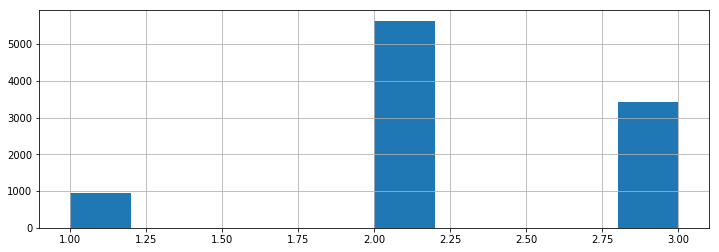

In [20]:
df = pd.read_csv("C:/DAT102X Microsoft Professional Capstone  Data Science/Data/Training_values.csv")
damages = pd.read_csv("C:/DAT102X Microsoft Professional Capstone  Data Science/Data/Training_labels.csv")

joined = df.set_index("building_id").join(damages.set_index("building_id"))


#joined = joined[joined["age"] < 100]
#joined = joined[joined["height"] < 15]
#joined = joined[joined["area"] < 200]
joined["age_group"] = joined["age"].apply(lambda x: AgeGroup(x) )
joined["height_group"] = joined["height"].apply(lambda x: HeightGroup(x) )

dfH_Norm = Normalize(pd.DataFrame(joined["height"]))
dfArea_Norm = Normalize(pd.DataFrame(joined["area"]))
dfAge_Norm = Normalize(pd.DataFrame(joined["age"]))


joined["height_n"] = dfH_Norm["height"]
joined["area_n"] = dfArea_Norm["area"]
joined["age_n"] = dfAge_Norm["age"]


columns = [
    "age",
    "height",
    "area",
    "age_n",
    #"height_n",
    #"age_group",
    "height_group",
    #"area_n",
    "count_families",
    "count_floors_pre_eq",
    #"foundation_type",
    #"ground_floor_type",
    "legal_ownership_status",
    "plan_configuration",
    "has_secondary_use_other",
    "has_secondary_use_agriculture",
    "has_secondary_use_hotel",
    "has_secondary_use_rental",
    "has_secondary_use_health_post",
    "has_secondary_use_gov_office",
    "has_secondary_use_school",
    "has_secondary_use_use_police",
    "has_secondary_use_industry",
    "has_secondary_use_institution",
    #"roof_type",
    #'has_superstructure_adobe_mud', 
    #'has_superstructure_mud_mortar_stone',
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 
    #'has_superstructure_timber',
    'has_superstructure_bamboo', 
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 
    'has_superstructure_other'
]

joined.drop(columns,inplace=True,axis = 1)

joined.reset_index(inplace = True)

joined = pd.get_dummies(joined)

joined["damage_grade"].hist()
plt.show()

In [39]:
#Perform Upsampling
train1 = Balance(joined,2000)
train2 = Balance(joined,3500)
train3 = Balance(joined,5000)

target = 'damage_grade'
IDcol = 'building_id'
predictors = [x for x in joined.columns if x not in [target, IDcol]]
model = GradientBoostingClassifier(random_state=10)

print("\nUpsampling 2000")
print("-----------------------")
modelfit(model, train1, predictors)
print("\nUpsampling 3500")
print("-----------------------")
modelfit(model, train2, predictors)
print("\nUpsampling 5000")
print("-----------------------")
modelfit(model, train3, predictors)
print("\nOriginal Data")
print("-----------------------")
modelfit(model, joined, predictors)


Upsampling 2000
-----------------------

Model Report
Accuracy : 0.7315
Micro F1 : 0.7315
CV Score : Mean - 0.6823333 | Std - 0.01856221 | Min - 0.6575 | Max - 0.7125

Upsampling 3500
-----------------------

Model Report
Accuracy : 0.7108
Micro F1 : 0.7108
CV Score : Mean - 0.6866667 | Std - 0.01339103 | Min - 0.6695238 | Max - 0.7042857

Upsampling 5000
-----------------------

Model Report
Accuracy : 0.7064
Micro F1 : 0.7064
CV Score : Mean - 0.6855333 | Std - 0.009602315 | Min - 0.6706667 | Max - 0.701

Original Data
-----------------------

Model Report
Accuracy : 0.6974
Micro F1 : 0.6974
CV Score : Mean - 0.6674028 | Std - 0.01239362 | Min - 0.646 | Max - 0.6833417


In [24]:
predictors = [x for x in joined.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators': [2000,2500,3000]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=20,min_samples_leaf=20,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train1[predictors],train1[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.78650, std: 0.01622, params: {'n_estimators': 2000},
  mean: 0.78433, std: 0.01681, params: {'n_estimators': 2500},
  mean: 0.78500, std: 0.01782, params: {'n_estimators': 3000}],
 {'n_estimators': 2000},
 0.7865)

In [31]:
param_test2 = {
    #'max_depth':[int(x) for x in np.linspace(start = 10, stop = 15, num = 5)], 
    #'min_samples_split':[int(x) for x in np.linspace(start = 10, stop = 20, num = 5)]
    'max_depth':[12,16,24], 
    'min_samples_split':[200]
}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=2000, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train1[predictors],train1[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.78950, std: 0.01455, params: {'max_depth': 12, 'min_samples_split': 200},
  mean: 0.78583, std: 0.01323, params: {'max_depth': 16, 'min_samples_split': 200},
  mean: 0.78750, std: 0.01090, params: {'max_depth': 24, 'min_samples_split': 200}],
 {'max_depth': 12, 'min_samples_split': 200},
 0.7895)

In [33]:
param_test3 = {
    'min_samples_split':[200], 
    'min_samples_leaf':[100,150,200]
}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=2000,max_depth=12,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train1[predictors],train1[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84971, std: 0.00901, params: {'min_samples_leaf': 100, 'min_samples_split': 200},
  mean: 0.84924, std: 0.00501, params: {'min_samples_leaf': 150, 'min_samples_split': 200},
  mean: 0.83848, std: 0.00632, params: {'min_samples_leaf': 200, 'min_samples_split': 200}],
 {'min_samples_leaf': 100, 'min_samples_split': 200},
 0.8497142857142856)

In [41]:
gsearch3.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=12,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=200,
              min_weight_fraction_leaf=0.0, n_estimators=2000,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False)


Model Report
Accuracy : 0.9997
Micro F1 : 0.9997
Confusion Matrix
Predicted     1     2     3  __all__
Actual                              
1          3500     0     0     3500
2             2  3498     0     3500
3             0     1  3499     3500
__all__    3502  3499  3499    10500
CV Score : Mean - 0.8497143 | Std - 0.009007933 | Min - 0.8366667 | Max - 0.8638095


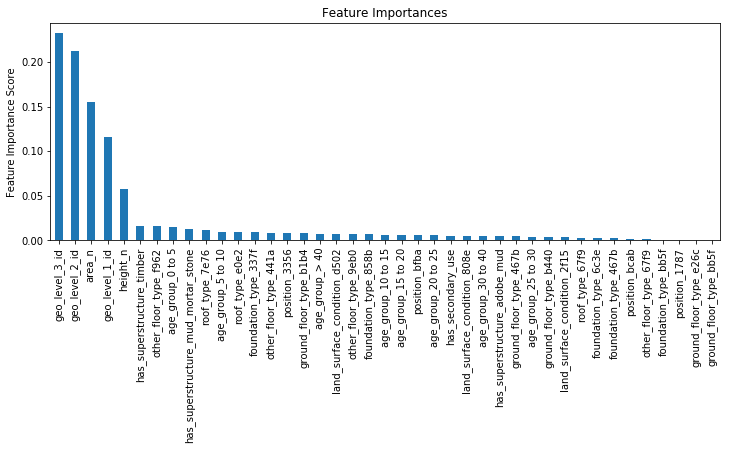

In [46]:

modelfit(gsearch3.best_estimator_, train2, predictors)

In [47]:
confusion_matrix

NameError: name 'confusion_matrix' is not defined

In [37]:
test_data = pd.read_csv("C:/DAT102X Microsoft Professional Capstone  Data Science/Data/Test_values.csv")

test_data["age_group"] = test_data["age"].apply(lambda x: AgeGroup(x) )
test_data["height_group"] = test_data["height"].apply(lambda x: HeightGroup(x) )

dfH_Norm = Normalize(pd.DataFrame(test_data["height"]))
dfArea_Norm = Normalize(pd.DataFrame(test_data["area"]))
dfAge_Norm = Normalize(pd.DataFrame(test_data["age"]))


test_data["height_n"] = dfH_Norm["height"]
test_data["area_n"] = dfArea_Norm["area"]
test_data["age_n"] = dfAge_Norm["age"]


columns = [
    "building_id",
    "ScoredLabels",
    "age",
    "height",
    "area",
    "age_n",
    #"height_n",
    #"age_group",
    "height_group",
    #"area_n",
    "count_families",
    "count_floors_pre_eq",
    #"foundation_type",
    #"ground_floor_type",
    "legal_ownership_status",
    "plan_configuration",
    "has_secondary_use_other",
    "has_secondary_use_agriculture",
    "has_secondary_use_hotel",
    "has_secondary_use_rental",
    "has_secondary_use_health_post",
    "has_secondary_use_gov_office",
    "has_secondary_use_school",
    "has_secondary_use_use_police",
    "has_secondary_use_industry",
    "has_secondary_use_institution",
    #"roof_type",
    #'has_superstructure_adobe_mud', 
    #'has_superstructure_mud_mortar_stone',
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 
    #'has_superstructure_timber',
    'has_superstructure_bamboo', 
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 
    'has_superstructure_other'
]
x_test_data = test_data.drop(columns,axis = 1)

x_test_data = pd.get_dummies(x_test_data)

test_data_predictions = model.predict(x_test_data)

df["damage_grade"] = test_data_predictions
df.to_csv("C:/DAT102X Microsoft Professional Capstone  Data Science/Data/Submission_20180415_02.csv",index=False)